In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
from src.Estimation.MLE import computeMLETransitionMatrix
from src.Simulator.SSA import SSASimulator
from src.Plotter.SystemPlotter import SysPlotter

# MLE for Three State Lotka Voltera Model 

In [22]:
from src.Models.models import ThreeSpeciesModel
model = ThreeSpeciesModel()
simulator = SSASimulator(model)

parameters = model.getDefaultParameter()
y, t = simulator.run_ssa(np.array([80000, 10, 10]), 100, parameters)

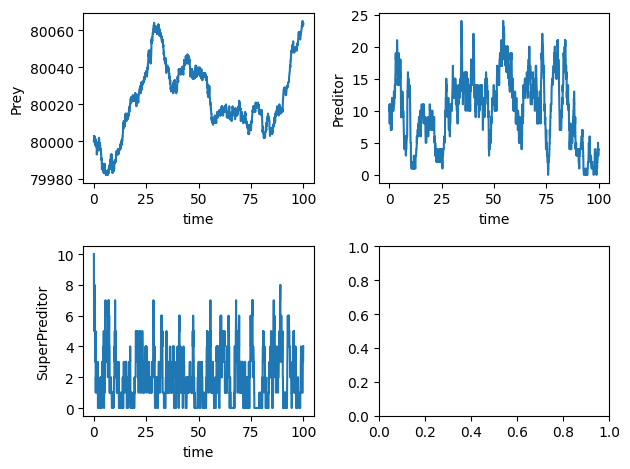

In [23]:
plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model)

In [14]:
MLETransitionRateMatrix = computeMLETransitionMatrix(y, t)

In [ ]:
state = np.array([10 ** 5, 10, 10])
t = 0
props = model.getPropensities(state, t)
stoich = model.getStoichiometry()

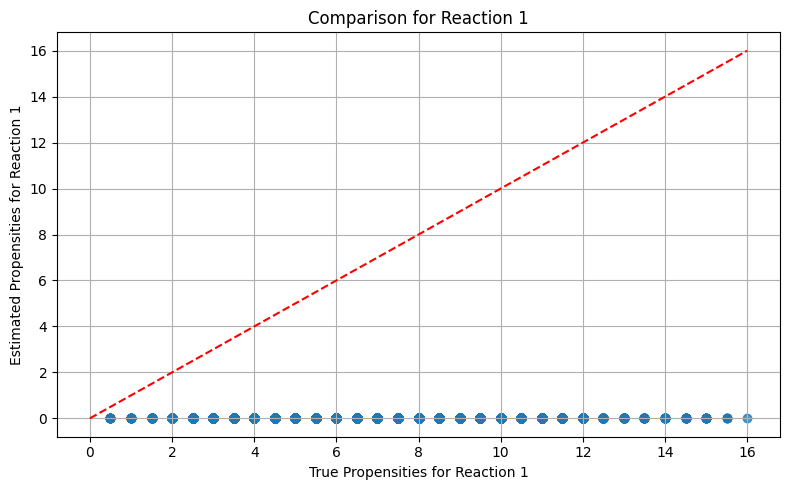

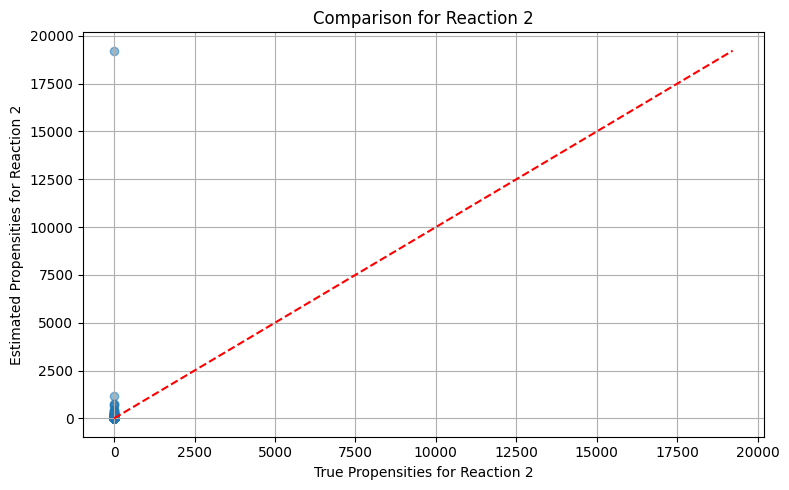

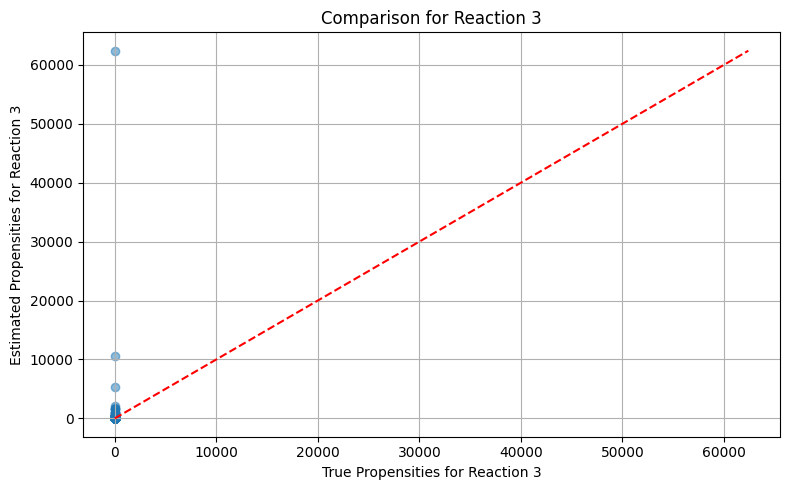

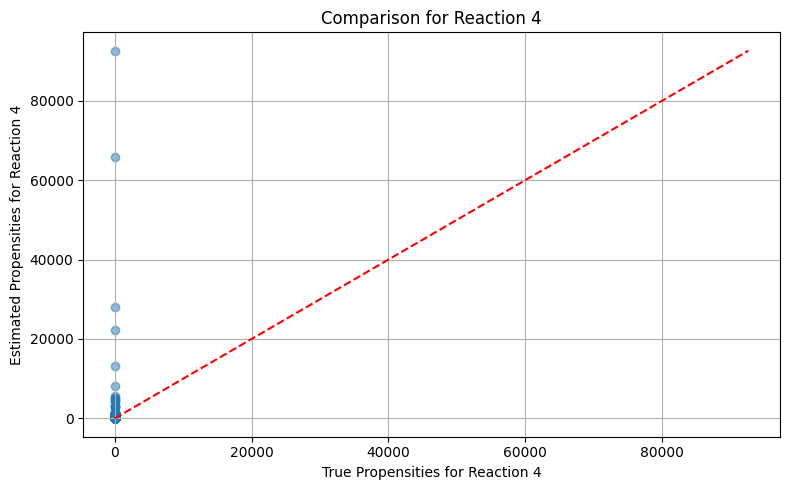

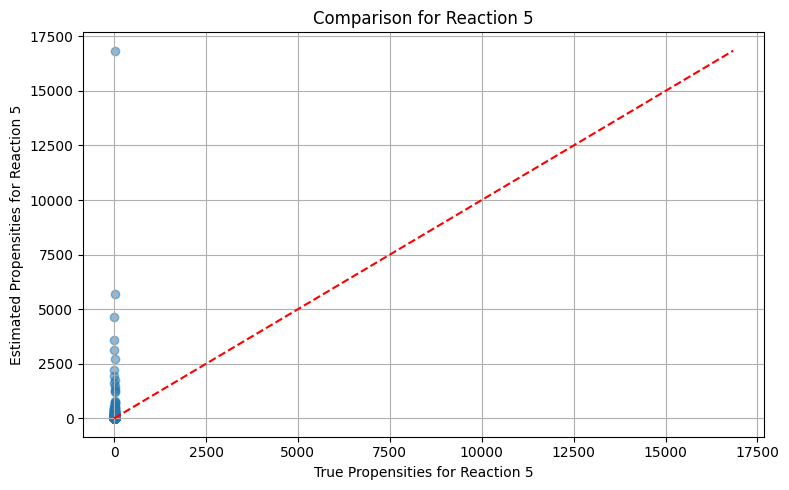

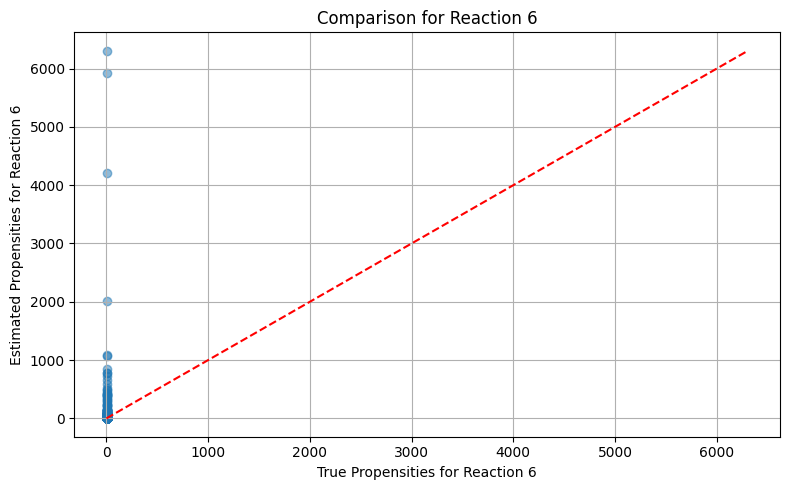

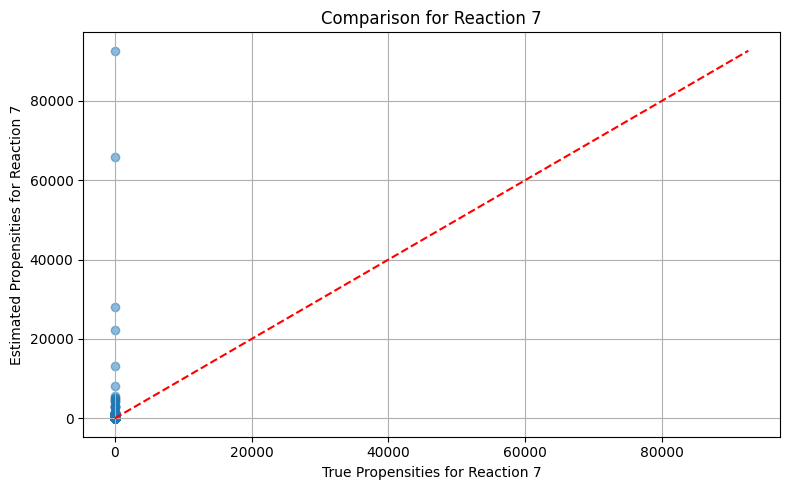

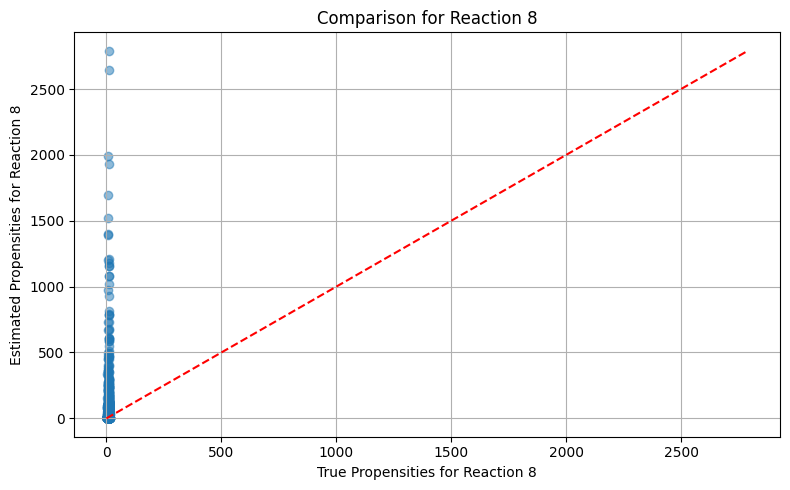

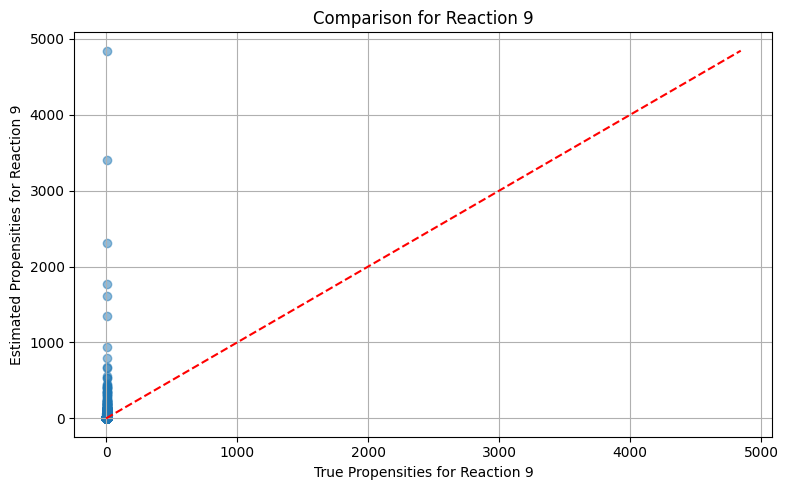

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Get stoichiometry matrix
stoich = model.getStoichiometry()

# Get unique states
states, unique_indices = np.unique(np.vstack(y), axis=0, return_inverse=True)

# Convert stoichiometry matrix rows to strings to make them hashable.
stoich_dict = {}
for r, s in enumerate(stoich):
    key = tuple(s)
    stoich_dict.setdefault(key, []).append(r)

# Construct the reactions_mapping
reactions_mapping = {}
for i, source_state in enumerate(states):
    for j, target_state in enumerate(states):
        difference = tuple(target_state - source_state)
        matching_reactions = stoich_dict.get(difference, [])
        
        if matching_reactions:
            key = (i, j)
            reactions_mapping[key] = matching_reactions[0] if len(matching_reactions) == 1 else tuple(matching_reactions)

# Extract estimated propensities from the MLE matrix using the above mapping
estimated_propensities = np.zeros((len(y), stoich.shape[0]))

for i, idx in enumerate(unique_indices[:-1]):
    for j in range(len(states)):
        # When accessing the mapping in subsequent code:
        reaction_idx = reactions_mapping.get((idx, j))
        if reaction_idx:
            if isinstance(reaction_idx, tuple):  # Check if there are multiple reactions with the same stoichiometry
                for r in reaction_idx:
                    estimated_propensities[i, r] += MLETransitionRateMatrix[idx, j]
            else:
                estimated_propensities[i, reaction_idx] = MLETransitionRateMatrix[idx, j]

# Calculate true propensities
true_propensities = np.zeros((len(y), stoich.shape[0]))
for i, state in enumerate(y):
    true_propensities[i] = model.getPropensities(state, t[i])

# Visualization
for j in range(stoich.shape[0]):
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Sum true propensities for reactions with the same stoichiometry
    sum_true_propensities = true_propensities[:, j]
    for k, s in enumerate(stoich):
        if k != j and np.array_equal(s, stoich[j]):
            sum_true_propensities += true_propensities[:, k]
    
    ax.scatter(sum_true_propensities, estimated_propensities[:, j], alpha=0.5)
    ax.set_xlabel(f'True Propensities for Reaction {j+1}')
    ax.set_ylabel(f'Estimated Propensities for Reaction {j+1}')
    
    min_val = min(sum_true_propensities.min(), estimated_propensities[:, j].min())
    max_val = max(sum_true_propensities.max(), estimated_propensities[:, j].max())
    
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')  # Line of perfect fit for reference
    ax.grid(True)
    plt.title(f"Comparison for Reaction {j+1}")
    plt.tight_layout()
    plt.show()
